In [1]:
%matplotlib inline

/Users/ihuangyiran/anaconda2/envs/py3-tf/lib/python3.6/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [3]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

from tensorflow.contrib.tensorboard.plugins import projector
from tensorflow.examples.tutorials.mnist import input_data

In [5]:
LOG_DIR = "./log/minimalsample"
NAME_TO_VISUALISE_VARIABLE = 'ministembedding'
TO_EMBED_COUNT = 500

path_for_mnist_sprites = os.path.join(LOG_DIR, 'mnistdigits.png')
path_for_mnist_metadata = os.path.join(LOG_DIR, 'metadata.tsv')

mnist = input_data.read_data_sets('MNIST_data/', one_hot = False)
batch_xs, batch_ys = mnist.train.next_batch(TO_EMBED_COUNT)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [6]:
# 建立embeddings，最主要的是要知道可视化查看的variable的名字
embedding_var = tf.Variable(batch_xs, name = NAME_TO_VISUALISE_VARIABLE)
summary_writer = tf.summary.FileWriter(LOG_DIR)

In [9]:
# build embedding projectorc
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.tensor_name = embedding_var.name

embedding.metadata_path = path_for_mnist_metadata

embedding.sprite.image_path = path_for_mnist_sprites # we will create this later
embedding.sprite.single_image_dim.extend([28, 28])

# say that you want to visualise the embeddings
projector.visualize_embeddings(summary_writer, config)

In [11]:
# Second step
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()
saver.save(sess, os.path.join(LOG_DIR, 'model.ckpt'), 1)

'./log/minimalsample/model.ckpt-1'

In [16]:
# define helper functions: 
#  create_sprite_image: 将sprits整齐的对其在方形画布上
#  vector_to_matrix_mnist: 将MNIST的vector数据形式转化为images
#  invert_grayscale: 将黑背景变为白背景
def create_sprite_image(images):
    if isinstance(images, list):
        images = np.array(images)
    img_h = images.shape[1]
    img_w = images.shape[2]
    n_plots = int(np.ceil(np.sqrt(images.shape[0])))
    
    spriteimage = np.ones((img_h * n_plots, img_w * n_plots))
    
    for i in range(n_plots):
        for j in range(n_plots):
            this_filter = i * n_plots + j 
            if this_filter < images.shape[0]:
                this_img = images[this_filter]
                spriteimage[i * img_h: (i + 1) * img_h, 
                            j * img_w: (j + 1) * img_w] = this_img
    return spriteimage

def vector_to_matrix_mnist(mnist_digits):
    return np.reshape(mnist_digits, (-1, 28, 28))

def invert_grayscale(mnist_digits):
    return 1-mnist_digits

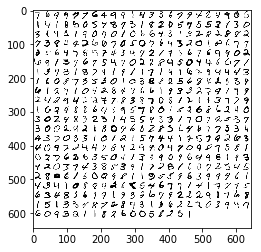

In [17]:
# save sprite image
to_visualise = batch_xs
to_visualise = vector_to_matrix_mnist(to_visualise)
to_visualise = invert_grayscale(to_visualise)

sprite_image = create_sprite_image(to_visualise)

plt.imsave(path_for_mnist_sprites, sprite_image, cmap = 'gray')
plt.imshow(sprite_image, cmap = 'gray')

In [18]:
# save metadata将数据写入metadata，因为如果想在可视化时看到不同数值用不同颜色表示，需要知道每个image的标签，
# 在这个metadata中有这样的两列： index, Label
with open(path_for_mnist_metadata, 'w') as f:
    f.write("Index\tLabel\n")
    for index, label in enumerate(batch_ys):
        f.write("%d\t%d\n" %(index, label))